# Loading Libraries 

In [ ]:
!pip install SPARQLWrapper torch transformers spacy pandas numpy matplotlib seaborn requests tqdm nltk transformers scikit-learn pickle5 lxml beautifulsoup4 wandb igraph


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import shutil
import os
from tqdm import tqdm
import nltk
from transformers import BertModel, BertTokenizer
from nltk.corpus import stopwords
from sklearn.svm import SVC
import pickle
import xml.etree.ElementTree as ET
import concurrent.futures
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import igraph as ig
import random
import torch
import wandb
from transformers import BertModel, BertTokenizer
from sklearn.metrics import classification_report

# Stats

The park_filtered.csv file contains biomedical literature data related to various genes and their associations filtered for Parkinson's disease. <br>
The "Inter-doc complete 93k.csv" file is an enhanced version of the "park_filtered.csv" dataset, including additional details such as the publication year, the number of citations, the journal name, and the journal's impact factor.


In [9]:
park_filtered = pd.read_csv('park_filtered.csv')
total_gd_rows_pd = len(park_filtered)
inter_doc = pd.read_csv('Inter-doc comnplete 93k.csv')                            
unique_genes = len(inter_doc['id1'].unique())
pmid_counts = inter_doc.groupby('id1')['PMID'].nunique()
id1_more_than_100 = len(pmid_counts[pmid_counts >= 100].index)
genes_less_100_papers = 11030 - id1_more_than_100

print('Total number of rows in Parkinsons Disease dataset:',total_gd_rows_pd)
print('Total number of unique genes in Parkinsons Disease dataset:',unique_genes)
print('Total number of genes occuring in 100 and more than 100 papers in Parkinsons dataset: ',id1_more_than_100)
print('Total number of genes occuring in less than 100 papers in Parkinsons dataset: ',genes_less_100_papers)


Total number of rows in Parkinsons Disease dataset: 111419
Total number of unique genes in Parkinsons Disease dataset: 11030
Total number of genes occuring in 100 and more than 100 papers in Parkinsons dataset:  111
Total number of genes occuring in less than 100 papers in Parkinsons dataset:  10919


# Processing

The text files contains PubTator format PubMed articles, including gene-disease entity pairs and other related information. A Python script processes this file to generate BERT format in TSV format. To enhance efficiency, the original text file has been split into 5 separate text files, each with its own Python script, resulting in 5 corresponding TSV files. <br>
Python files to convert txt files into tsv - part1.py, part2.py, part3.py, part4.py, part5.py <br>
Run these python files to get tsv files. Or you can directly skip one cell (the next code cell) to get the pre-processed data loaded

Preparing dataset for Parkinsons disease application

In [ ]:
# df1 = pd.read_csv('part1.tsv', sep='\t')
# df2 = pd.read_csv('part2.tsv', sep='\t')
# df3 = pd.read_csv('part3.tsv', sep='\t')
# df4 = pd.read_csv('part4.tsv', sep='\t')
# df5 = pd.read_csv('part5.tsv', sep='\t')

# df = pd.concat([df1, df2, df3, df4, df5], axis=0, ignore_index=True)
# df = df.drop_duplicates(subset = ['index','id1','id2','sentence'])
# df_filtered = df[df['id2']=='D010300']

# def get_gene_symbol(ncbi_id):
#     if ";" in str(ncbi_id):
#         ncbi_id = str(ncbi_id).split(";")[0]

#     url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
#     params = {
#         "db": "gene",
#         "id": ncbi_id,
#         "retmode": "json"
#     }
#     response = requests.get(url, params=params)
#     response.raise_for_status()
#     data = response.json()
#     gene_symbol = data["result"][str(ncbi_id)]["name"]
#     return gene_symbol


# def create_ncbi_to_gene_symbol_dict(ncbi_ids):
#     ncbi_to_gene_symbol = {}
#     error_ids = []
#     request_count = 0
    
#     for ncbi_id in tqdm(ncbi_ids, desc="Fetching gene symbols"):
#         if request_count > 0 and request_count % 3 == 0:
#             time.sleep(1)  # Sleep for 1 second after every 3 requests

#         try:
#             gene_symbol = get_gene_symbol(ncbi_id)
#             ncbi_to_gene_symbol[ncbi_id] = gene_symbol
#         except Exception as e:
#             print(f"Error fetching gene symbol for NCBI ID {ncbi_id}: {e}")
#             error_ids.append(ncbi_id)
        
#         request_count += 1
    
#     # Retry for error IDs
#     for ncbi_id in tqdm(error_ids, desc="Retrying for error IDs"):
#         if request_count > 0 and request_count % 3 == 0:
#             time.sleep(1)

#         try:
#             gene_symbol = get_gene_symbol(ncbi_id)
#             ncbi_to_gene_symbol[ncbi_id] = gene_symbol
#             error_ids.remove(ncbi_id)  # Remove from error list if successful
#         except Exception as e:
#             print(f"Error fetching gene symbol for NCBI ID {ncbi_id}: {e}")
        
#         request_count += 1
    
#     return ncbi_to_gene_symbol, error_ids


# ncbi_to_gene_symbol_dict, remaining_errors = create_ncbi_to_gene_symbol_dict(genes)

# df_filtered['Symbol'] = df_filtered['id1'].map(ncbi_to_gene_symbol_dict)




Run from here to load the pre-processed data

In [ ]:
# df_filtered=pd.read_csv('park_filtered.csv')

# park = df_filtered[df_filtered['id2']=='D010300']

# class ModelTrainer:
#     def __init__(self, df, model_name):
#         self.df = df
#         self.model_name = self.load_model(model_name)
#         self.tokenizer = self.load_tokenizer(model_name)

#     def load_model(self, model_name):
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         biobert = BertModel.from_pretrained(model_name).to(self.device)
#         print("BioBERT model loaded")
#         return biobert

#     def load_tokenizer(self, model_name):
#         tokenizer = BertTokenizer.from_pretrained(model_name)
#         print("Tokenizer loaded")
#         return tokenizer

#     def remove_stopwords(self, text):
#         stop_words = set(stopwords.words('english'))
#         tokens = nltk.word_tokenize(text)
#         tokens = [word for word in tokens if word.lower() not in stop_words]
#         return ' '.join(tokens)

#     def create_dataset(self):
#         # self.df['sentence'] = self.df['sentence'].apply(self.remove_stopwords)
#         X = self.df['sentence'].tolist()
#         print("Dataset created")
#         return X

#     def get_specific_token_embeddings(self, sentence):
#         inputs = self.tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512).to(self.device)
#         tokenized_sentence = self.tokenizer.tokenize(sentence)
#         gene_src_token = self.tokenizer.tokenize("@GeneSrc$")
#         disease_tgt_token = self.tokenizer.tokenize("@DiseaseTgt$")

#         gene_src_indices = [i for i, token in enumerate(tokenized_sentence) if token in gene_src_token]
#         disease_tgt_indices = [i for i, token in enumerate(tokenized_sentence) if token in disease_tgt_token]

#         with torch.no_grad():
#             outputs = self.model_name(**inputs)
#         embeddings = outputs.last_hidden_state[0]

#         context_range = 2

#         def get_context_embeddings(indices):
#             context_embeddings = []
#             for idx in indices:
#                 start = max(0, idx - context_range)
#                 end = min(idx + context_range + 1, len(tokenized_sentence))
#                 context = embeddings[start:end]
#                 context_embeddings.append(context)
#             return torch.cat(context_embeddings).view(-1, 768)

#         gene_src_embeddings = get_context_embeddings(gene_src_indices)
#         disease_tgt_embeddings = get_context_embeddings(disease_tgt_indices)

#         avg_gene_src_embedding = torch.mean(gene_src_embeddings, dim=0)
#         avg_disease_tgt_embedding = torch.mean(disease_tgt_embeddings, dim=0)

#         combined_embedding = torch.cat([avg_gene_src_embedding, avg_disease_tgt_embedding], dim=0)
#         combined_embedding_np = combined_embedding.cpu().numpy().reshape(1, -1)

#         if np.isnan(combined_embedding_np).any():
#             print(sentence)

#         return combined_embedding_np

#     def generate_embeddings(self):
#         X = self.create_dataset()
#         try:
#             X_embeddings = []
#             for sentence in tqdm(X):
#                 sentence_embedding = self.get_specific_token_embeddings(sentence)
#                 X_embeddings.append(sentence_embedding)
#             X_embeddings = np.vstack(X_embeddings)
#         except Exception as e:
#             print(e)
#             pass
#         print("Embeddings generated")
#         return X_embeddings

#     def svm_classification(self, embeddings):
#         print("Doing classification using SVM...")
        
#         with open('./model_non_gda.pkl', 'rb') as f:
#             non_gda_model = pickle.load(f)
        
#         # Initialize lists to store predictions and probabilities
#         predictions = []
#         probabilities = []
#         error_idx = []
#         for idx, embedding in enumerate(embeddings):
#             try:
#                 # Prediction probability for the current embedding
#                 proba = non_gda_model.predict_proba(embedding.reshape(1, -1))
#                 probabilities.append(proba[:, 1][0])
#                 # Prediction for the current embedding
#                 y_pred = non_gda_model.predict(embedding.reshape(1, -1))
#                 predictions.append(y_pred[0])
#             except Exception as e:
#                 print(f"Error at index {idx}: {e}")
#                 error_idx.append(idx)
#                 # Append NaN or any placeholder value to keep the lists aligned with the dataset
#                 probabilities.append(np.nan)
#                 predictions.append(np.nan)
#         # Add the prediction probabilities and predictions to the dataframe
#         self.df['non_gda_test_proba'] = probabilities
#         self.df['Prediction'] = predictions
        
#         # print(len(self.df['Prediction'].isna()))
#         self.df.to_csv('park_results.csv', index=False)
#         return error_idx

# df = df_filtered
# model_trainer = ModelTrainer(df, 'dmis-lab/biobert-base-cased-v1.1')
# embeddings = model_trainer.generate_embeddings()
# error_idx = model_trainer.svm_classification(embeddings)

# park_results = pd.read_csv('park_results.csv')
# df_filtered = df_filtered.drop(error_idx)


Fig. 8

/tmp/ipykernel_164821/1546340393.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  causal = grouped.apply(lambda x: x['Prediction'].sum())


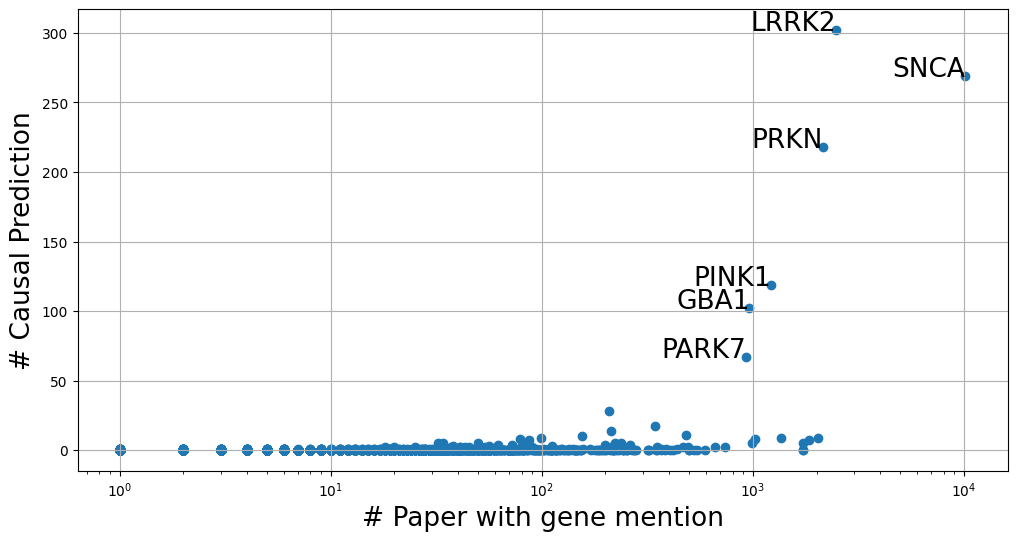

In [10]:
# Scatter Plot of Causal Papers vs. Number of Papers for Each Gene
df_filtered=pd.read_csv('park_filtered.csv')

park = df_filtered[df_filtered['id2']=='D010300']

# Group by 'id1' which refers to genes
grouped = df_filtered.groupby('id1')

# Calculate the number of causal papers (Prediction == 1) for each gene
causal = grouped.apply(lambda x: x['Prediction'].sum())

# Count the number of unique papers for each gene
num_papers = grouped['index'].nunique()

# Create a DataFrame for easier filtering
stats_df = pd.DataFrame({
    'num_papers': num_papers,
    'causal': causal,
    'Symbol': grouped['Symbol'].first()
})

# Create a scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(stats_df['num_papers'], stats_df['causal'])

# Add labels to each point where 'causal' is greater than or equal to 50
for i, row in stats_df.iterrows():
    if row['causal'] >= 50:
        plt.text(row['num_papers'], row['causal'], row['Symbol'], fontsize=19, ha='right')

# Set x-axis to log scale
plt.xscale('log')

plt.xlabel('# Paper with gene mention', fontsize=19)
# plt.xlabel('Number of Papers')
plt.ylabel('# Causal Prediction', fontsize=19)
# plt.title('Scatter Plot of Causal Papers vs. Number of Papers for Each Gene')
plt.grid(True)
plt.savefig('log zoomed out.png', bbox_inches='tight')
plt.show()

For CRED dataset

The following cell performs preprocessing, in order to directly load preprocessed dataset, skip this cell and run the next one

In [ ]:
# train = pd.read_csv('train hindex.csv')
# val = pd.read_csv('val hindex.csv')
# test = pd.read_csv('test hindex.csv')
# train = train.rename(columns={'H-index':'H-Index'})
# train.drop(columns=['Unnamed: 0'],inplace=True)
# val.drop(columns=['Unnamed: 0'],inplace=True)
# test.drop(columns=['Unnamed: 0'],inplace=True)
# df = pd.concat([train,test,val], axis=0)
# df.drop_duplicates(subset=['PMID','id1','id2','sentence'],inplace=True)
# df = df.dropna(subset=['H-Index'])

# # Download stopwords
# nltk.download('stopwords')

# # Now you can import and use stopwords
# from nltk.corpus import stopwords

# # Example usage
# stop_words = set(stopwords.words('english'))


# nltk.download('punkt')
# from nltk.tokenize import word_tokenize


# class model_trainer:
#     def __init__(self, df, model_name):
#         self.df = df
#         self.model_name = self.load_model(model_name)
#         self.tokenizer = self.load_tokenizer(model_name)

#     def load_model(self, model_name):
#         self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         biobert = BertModel.from_pretrained(model_name).to(self.device)
#         print("BioBERT model loaded")
#         return biobert

#     def load_tokenizer(self, model_name):
#         tokenizer = BertTokenizer.from_pretrained(model_name)
#         print("Tokenizer loaded")
#         return tokenizer

#     def remove_stopwords(self, text):
#         stop_words = set(stopwords.words('english'))
#         tokens = nltk.word_tokenize(text)
#         tokens = [word for word in tokens if word.lower() not in stop_words]
#         return ' '.join(tokens)

#     def create_dataset(self):
#         self.df['sentence'] = self.df['sentence'].apply(self.remove_stopwords)
        
#         X = self.df[['sentence', 'gda_score']].values.tolist()
#         y = self.df['label'].tolist()
        
#         print("Dataset created")

#         return X, y

#     def get_specific_token_embeddings(self, sentence):
#         inputs = self.tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512).to(self.device)
#         tokenized_sentence = self.tokenizer.tokenize(sentence)
#         gene_src_token = self.tokenizer.tokenize("@GeneSrc$")
#         disease_tgt_token = self.tokenizer.tokenize("@DiseaseTgt$")

#         gene_src_indices = [i for i, token in enumerate(tokenized_sentence) if token in gene_src_token]
#         disease_tgt_indices = [i for i, token in enumerate(tokenized_sentence) if token in disease_tgt_token]

#         with torch.no_grad():
#             outputs = self.model_name(**inputs)
#         embeddings = outputs.last_hidden_state[0]

#         context_range = 2

#         def get_context_embeddings(indices):
#             context_embeddings = []
#             for idx in indices:
#                 start = max(0, idx - context_range)
#                 end = min(idx + context_range + 1, len(tokenized_sentence))
#                 context = embeddings[start:end]
#                 context_embeddings.append(context)
#             return torch.cat(context_embeddings).view(-1, 768)

#         gene_src_embeddings = get_context_embeddings(gene_src_indices)
#         disease_tgt_embeddings = get_context_embeddings(disease_tgt_indices)

#         avg_gene_src_embedding = torch.mean(gene_src_embeddings, dim=0)
#         avg_disease_tgt_embedding = torch.mean(disease_tgt_embeddings, dim=0)

#         combined_embedding = torch.cat([avg_gene_src_embedding, avg_disease_tgt_embedding], dim=0)
#         combined_embedding_np = combined_embedding.cpu().numpy().reshape(1, -1)

#         if np.isnan(combined_embedding_np).any():
#             print(sentence)

#         return combined_embedding_np

#     def generate_embeddings(self):
#         X, y = self.create_dataset()
#         try:
#             embeddings = []
#             for sentence, gda_score in tqdm(X):
#                 sentence_embedding = self.get_specific_token_embeddings(sentence)
#                 gda_score = np.array([[gda_score]], dtype=np.float32)  # Ensure gda_score is a numpy array with correct dtype
#                 embedding_with_score_window = np.concatenate([sentence_embedding], axis=1)
#                 embeddings.append(embedding_with_score_window)
#             embeddings = np.vstack(embeddings)

#         except Exception as e:
#             print(e)
#             pass
#         print("Embeddings generated")
#         return embeddings, y

# trainer = model_trainer(df=df, model_name="dmis-lab/biobert-base-cased-v1.1")
# X_embeddings, y_labels = trainer.generate_embeddings()


# # Usage outside the class
# def predict_and_update_df(df, model_path, embeddings):
#     # Load pre-trained model
#     with open(model_path, 'rb') as f:
#         model = pickle.load(f)
#     print("Pre-trained model loaded")

#     # Predict
#     predictions = model.predict(embeddings)
    
#     # Add predictions to DataFrame
#     df['prediction'] = predictions
#     print("Predictions added to DataFrame")
#     return df

# model_path = "model_non_gda.pkl"
# df = predict_and_update_df(df, model_path, X_embeddings)

# special_pmid = df[df['PMID']==15717024]
# # special_pmid.to_csv('special_pmid', index=False)

# gd_grouped = special_pmid.groupby(['id1', 'id2'])['PMID'].count().reset_index()
# gd_grouped = gd_grouped.rename(columns={'PMID': 'gd abstract count'}) 
# # Count number of pairs where label == 1
# causal_counts = special_pmid.groupby(['id1', 'id2'])['label'].sum().reset_index()
# causal_counts = causal_counts.rename(columns={'label': 'Causal_annotations'})

# # Merge
# gd_grouped = pd.merge(gd_grouped, causal_counts, on=['id1', 'id2'], how='left')

# gd_grouped['Causal/Total'] = gd_grouped['Causal_annotations'] / gd_grouped['gd abstract count']
# # print(gd_grouped)

# pred_counts = special_pmid.groupby(['id1', 'id2'])['prediction'].sum().reset_index()
# pred_counts = pred_counts.rename(columns={'prediction': 'Prediction_counts'})

# # Merge
# gd_grouped = pd.merge(gd_grouped, pred_counts, on=['id1', 'id2'], how='left')

# gene_grouped = df.groupby('id1')['PMID'].count().reset_index()
# gene_grouped.rename(columns={'PMID': 'gene abstract count'}, inplace=True)

# dis_grouped = df.groupby('id2')['PMID'].count().reset_index()
# dis_grouped.rename(columns={'PMID': 'disease abstract count'}, inplace=True)

# special_pmid = pd.merge(special_pmid, gene_grouped, on='id1', how='left')
# special_pmid = pd.merge(special_pmid, dis_grouped, on='id2', how='left')
# special_pmid = pd.merge(special_pmid, gd_grouped, on=['id1', 'id2'], how='left')

# # special_pmid.to_csv('special_pmid_gd_grouped.csv', index=False)
# special_pmid.to_csv('special_pmid.csv', index=False)
# print(special_pmid)

# gd_grouped = pd.merge(gd_grouped, gene_grouped, on='id1', how='left')
# gd_grouped = pd.merge(gd_grouped, dis_grouped, on='id2', how='left')
# gene_grouped = df.groupby('id1')['PMID'].count().reset_index()
# gene_grouped.rename(columns={'PMID': 'gene abstract count'}, inplace=True)
# gd_grouped = df.groupby(['id1', 'id2'])['PMID'].count().reset_index()
# gd_grouped = gd_grouped.rename(columns={'PMID': 'gd abstract count'}) 

# causal_counts = df.groupby(['id1', 'id2'])['label'].sum().reset_index()
# causal_counts = causal_counts.rename(columns={'label': 'Causal_annotations'})

# # Merge
# gd_grouped = pd.merge(gd_grouped, causal_counts, on=['id1', 'id2'], how='left')

# gd_grouped['Causal/Total'] = gd_grouped['Causal_annotations'] / gd_grouped['gd abstract count']

# df = pd.merge(df, gene_grouped, on='id1', how='left')
# df = pd.merge(df, dis_grouped, on='id2', how='left')
# df = pd.merge(df, gd_grouped, on=['id1', 'id2'], how='left')

# prediction_counts = df.groupby(['id1', 'id2'])['prediction'].sum().reset_index()
# prediction_counts = prediction_counts.rename(columns={'prediction': 'Prediction_counts'})
# gd_grouped = pd.merge(gd_grouped, prediction_counts, on=['id1', 'id2'], how='left')

# gd_grouped = pd.merge(gd_grouped, gene_grouped, on='id1', how='left')

# # Left merge dis_grouped into the updated gd_grouped on 'id2'
# gd_grouped = pd.merge(gd_grouped, dis_grouped, on='id2', how='left')
# gd_grouped = gd_grouped.rename(columns={'id1': 'Gene', 'id2': 'Disease'})
# # Save the DataFrame to a CSV file
# gd_grouped.to_csv('gene_disease_grouped.csv', index=False)
# df = pd.read_csv('gene_disease_grouped.csv')
# causal = df['Causal/Total'].value_counts()
# causal.sort_index(ascending=False)

# # Your email address to be included in Entrez API requests
# email = "vanshkapoor9911@gmail.com"

# def get_gene_symbol(ncbi_gene_id):
#     # Define the Entrez URL
#     url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id={ncbi_gene_id}&retmode=xml&email={email}"
    
#     # Make the request to Entrez
#     response = requests.get(url)
#     # Parse the XML response
#     root = ET.fromstring(response.content)
    
#     gene_symbol = None
#     # Extract the gene symbol from the XML
#     for docsum in root.findall(".//DocumentSummary"):
#         gene_symbol = docsum.findtext("Name")
#         break
    
#     return gene_symbol

# # Add a new column 'Symbol' with a progress bar
# tqdm.pandas()

# # Counter for managing requests
# request_counter = 0

# def wrapper_function(ncbi_gene_id):
#     global request_counter
#     request_counter += 1

#     # Every 3 requests, pause for 1 second
#     if request_counter % 3 == 0:
#         time.sleep(1)
    
#     return get_gene_symbol(ncbi_gene_id)

# # Apply the function with tqdm
# df['Gene Symbol'] = df['Gene'].progress_apply(wrapper_function)

# # Extract unique MeSH IDs
# mesh_ids = df['Disease'].unique()

# def get_disease_name_from_mesh(mesh_id):
#     if mesh_id == 'D002493':
#         return 'Unspecified'
    
#     url = f"https://id.nlm.nih.gov/mesh/{mesh_id}.json"
#     try:
#         response = requests.get(url)
#         response.raise_for_status()  # Check for HTTP errors
#         data = response.json()
        
#         # Check if the data is a dictionary or a list
#         if isinstance(data, dict):
#             # Extract the disease name from the 'label' field if it's a dictionary
#             disease_name = data.get('label', {}).get('@value', None)
#         elif isinstance(data, list) and len(data) > 0 and isinstance(data[0], dict):
#             # If the data is a list of dictionaries, extract the name from the first dictionary
#             disease_name = data[0].get('label', {}).get('@value', None)
#         else:
#             # If data format is unexpected
#             disease_name = None
        
#         return disease_name
#     except requests.RequestException as e:
#         print(f"Error fetching data for MeSH ID {mesh_id}: {e}")
#         return None

# # Initialize dictionary and list to store MeSH ID to Disease Name mapping and failed IDs
# mesh_to_disease_dict = {}
# failed_mesh_ids = []

# # Fetch disease names for each MeSH ID
# for i, mesh_id in enumerate(tqdm(mesh_ids, desc="Fetching Disease Names")):
#     # Fetch the disease name
#     disease_name = get_disease_name_from_mesh(mesh_id)
#     if disease_name:
#         mesh_to_disease_dict[mesh_id] = disease_name
#     else:
#         failed_mesh_ids.append(mesh_id)
    
#     # Sleep for 1 second after every 3 iterations
#     if (i + 1) % 3 == 0:
#         time.sleep(1)

# # Add 'Disease' column to DataFrame
# df['Disease Symbol'] = df['Disease'].map(mesh_to_disease_dict)

# # Print failed MeSH IDs
# if failed_mesh_ids:
#     print("Failed to fetch data for the following MeSH IDs:")
#     print(failed_mesh_ids)

# df['Disease Symbol'] = df['Disease Symbol'].fillna('ASPARTYL-tRNA SYNTHETASE DEFICIENCY')
# df['Disease Symbol'] = df['Disease Symbol'].replace('Unspecified', 'CNS DIS')



In [11]:
# Run pre-processed file
df = pd.read_csv('gene_disease_grouped.csv')

df['gd_pair'] = df['Gene Symbol'].astype(str) + '-' + df['Disease Symbol']

# Group by 'gd_pair' which refers to gene-disease pairs
grouped = df.groupby('gd_pair')

# Calculate the total Causal_annotations for each gene-disease pair
causal = grouped['Causal_annotations'].sum()

# Count the number of gene-disease abstracts for each gene-disease pair (assuming 'gd abstract count' column represents this)
gd_abstract_count = grouped['gd abstract count'].sum()

# Create a DataFrame for easier filtering and plotting
stats_df = pd.DataFrame({
    'gd_abstract_count': gd_abstract_count,
    'causal': causal,
    'gd_pair': grouped['gd_pair'].first()
})


In [27]:
# top_20 = df.sort_values(by=['Causal/Total','Causal_annotations'], ascending=False)[:20]
# top_4 = top_20[['Gene Symbol', 'Disease Symbol', 'Causal/Total']][:4]
# top_4.rename(columns={'Gene Symbol':'Gene','Disease Symbol':'Disease','Causal/Total':'Causal Score'}, inplace=True)
# top_4.to_csv('causal ratio top 4.csv',index=False)
# top_4

In [28]:
# # Top 25 graph
# # Set a random seed for reproducibility
# random.seed(40)  # You can choose any number as the seed

# # Sort the DataFrame by 'Causal/Total' and 'Causal_annotations' in descending order and keep the top 250
# top_df = df.sort_values(by=['Causal/Total', 'Causal_annotations'], ascending=False).head(20)

# # Filter out the genes to remove
# top_df_filtered = top_df

# # Create a graph
# g = ig.Graph()

# # Add vertices for Genes (Gene Symbol) and Diseases (Disease Symbol)
# genes = top_df_filtered['Gene Symbol'].unique()
# diseases = top_df_filtered['Disease Symbol'].unique()
# g.add_vertices(list(genes) + list(diseases))

# # Add edges with weights (Causal/Total)
# for _, row in top_df_filtered.iterrows():
#     g.add_edge(row['Gene Symbol'], row['Disease Symbol'], weight=row['Causal/Total'])

# # Normalize the edge weights to range from 0 to 1
# weights = [e["weight"] for e in g.es]
# norm = mcolors.Normalize(vmin=0.5, vmax=1.0)

# # Create a custom colormap that transitions from light green to dark green
# def create_custom_green_cmap(start_color='lightgreen', end_color='darkgreen'):
#     colors = [start_color, end_color]
#     cmap = mcolors.LinearSegmentedColormap.from_list('custom_green', colors)
#     return cmap

# green_cmap = create_custom_green_cmap()

# # Apply the custom colormap to the normalized weights
# edge_colors = [green_cmap(norm(weight)) for weight in weights]

# # Plot the graph
# fig, ax = plt.subplots(figsize=(10, 8))
# layout = g.layout("fr")  # The layout is now reproducible due to the fixed seed

# # Plot the main graph
# for idx, vertex in enumerate(g.vs["name"]):
#     x, y = layout[idx]
#     if vertex in genes:
#         circle = plt.Circle((x, y), 0.4, color='skyblue', zorder=3)
#         ax.add_patch(circle)
#         ax.text(x, y, vertex, horizontalalignment='center', verticalalignment='center', color="black", fontsize=12, zorder=4)
#     elif vertex in diseases:
#         rect_width = max(0.22 * len(vertex), 0.5)  # Adjust width based on text length, with a minimum width
#         rect_height = 0.35  # Adjust height based on your layout scale
#         rect = mpatches.Rectangle(
#             (x - rect_width / 2, y - rect_height / 2), 
#             rect_width, 
#             rect_height, 
#             facecolor="white", edgecolor="black", linewidth=2, zorder=2
#         )
#         ax.add_patch(rect)
#         ax.text(x, y, vertex, horizontalalignment='center', verticalalignment='center', color="black", fontsize=12, zorder=3)

# # Plot edges with varying widths and colors
# for e in g.es:
#     source, target = e.tuple
#     x_coords = [layout[source][0], layout[target][0]]
#     y_coords = [layout[source][1], layout[target][1]]
#     ax.plot(x_coords, y_coords, color=edge_colors[e.index], lw=2 + 8 * norm(e['weight']), zorder=1)

# # Add color bar for edge weights
# sm = plt.cm.ScalarMappable(cmap=green_cmap, norm=norm)
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label('Causal Score', fontsize=16)
# cbar.ax.tick_params(labelsize=14)
# # cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0]) 
# # cbar.ax.set_ylim([0, 1.0])

# # Add legend to the main plot with increased fontsize
# ax.legend(handles=[
#     plt.Line2D([0], [0], marker='o', color='w', label='Gene', markerfacecolor='skyblue', markersize=10),
#     mpatches.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', linewidth=2, label='Disease')
# ], loc='upper right', fontsize=14)  # Increase fontsize to 14

# ax.set_xticks([])  # Remove x-axis ticks
# ax.set_yticks([])  # Remove y-axis ticks

# plt.show()

# # Save the graph as an image file
# fig.savefig('cred_causal_ratio_with_inset_20.png', bbox_inches='tight')


Fig. 9

/tmp/ipykernel_164821/478317040.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


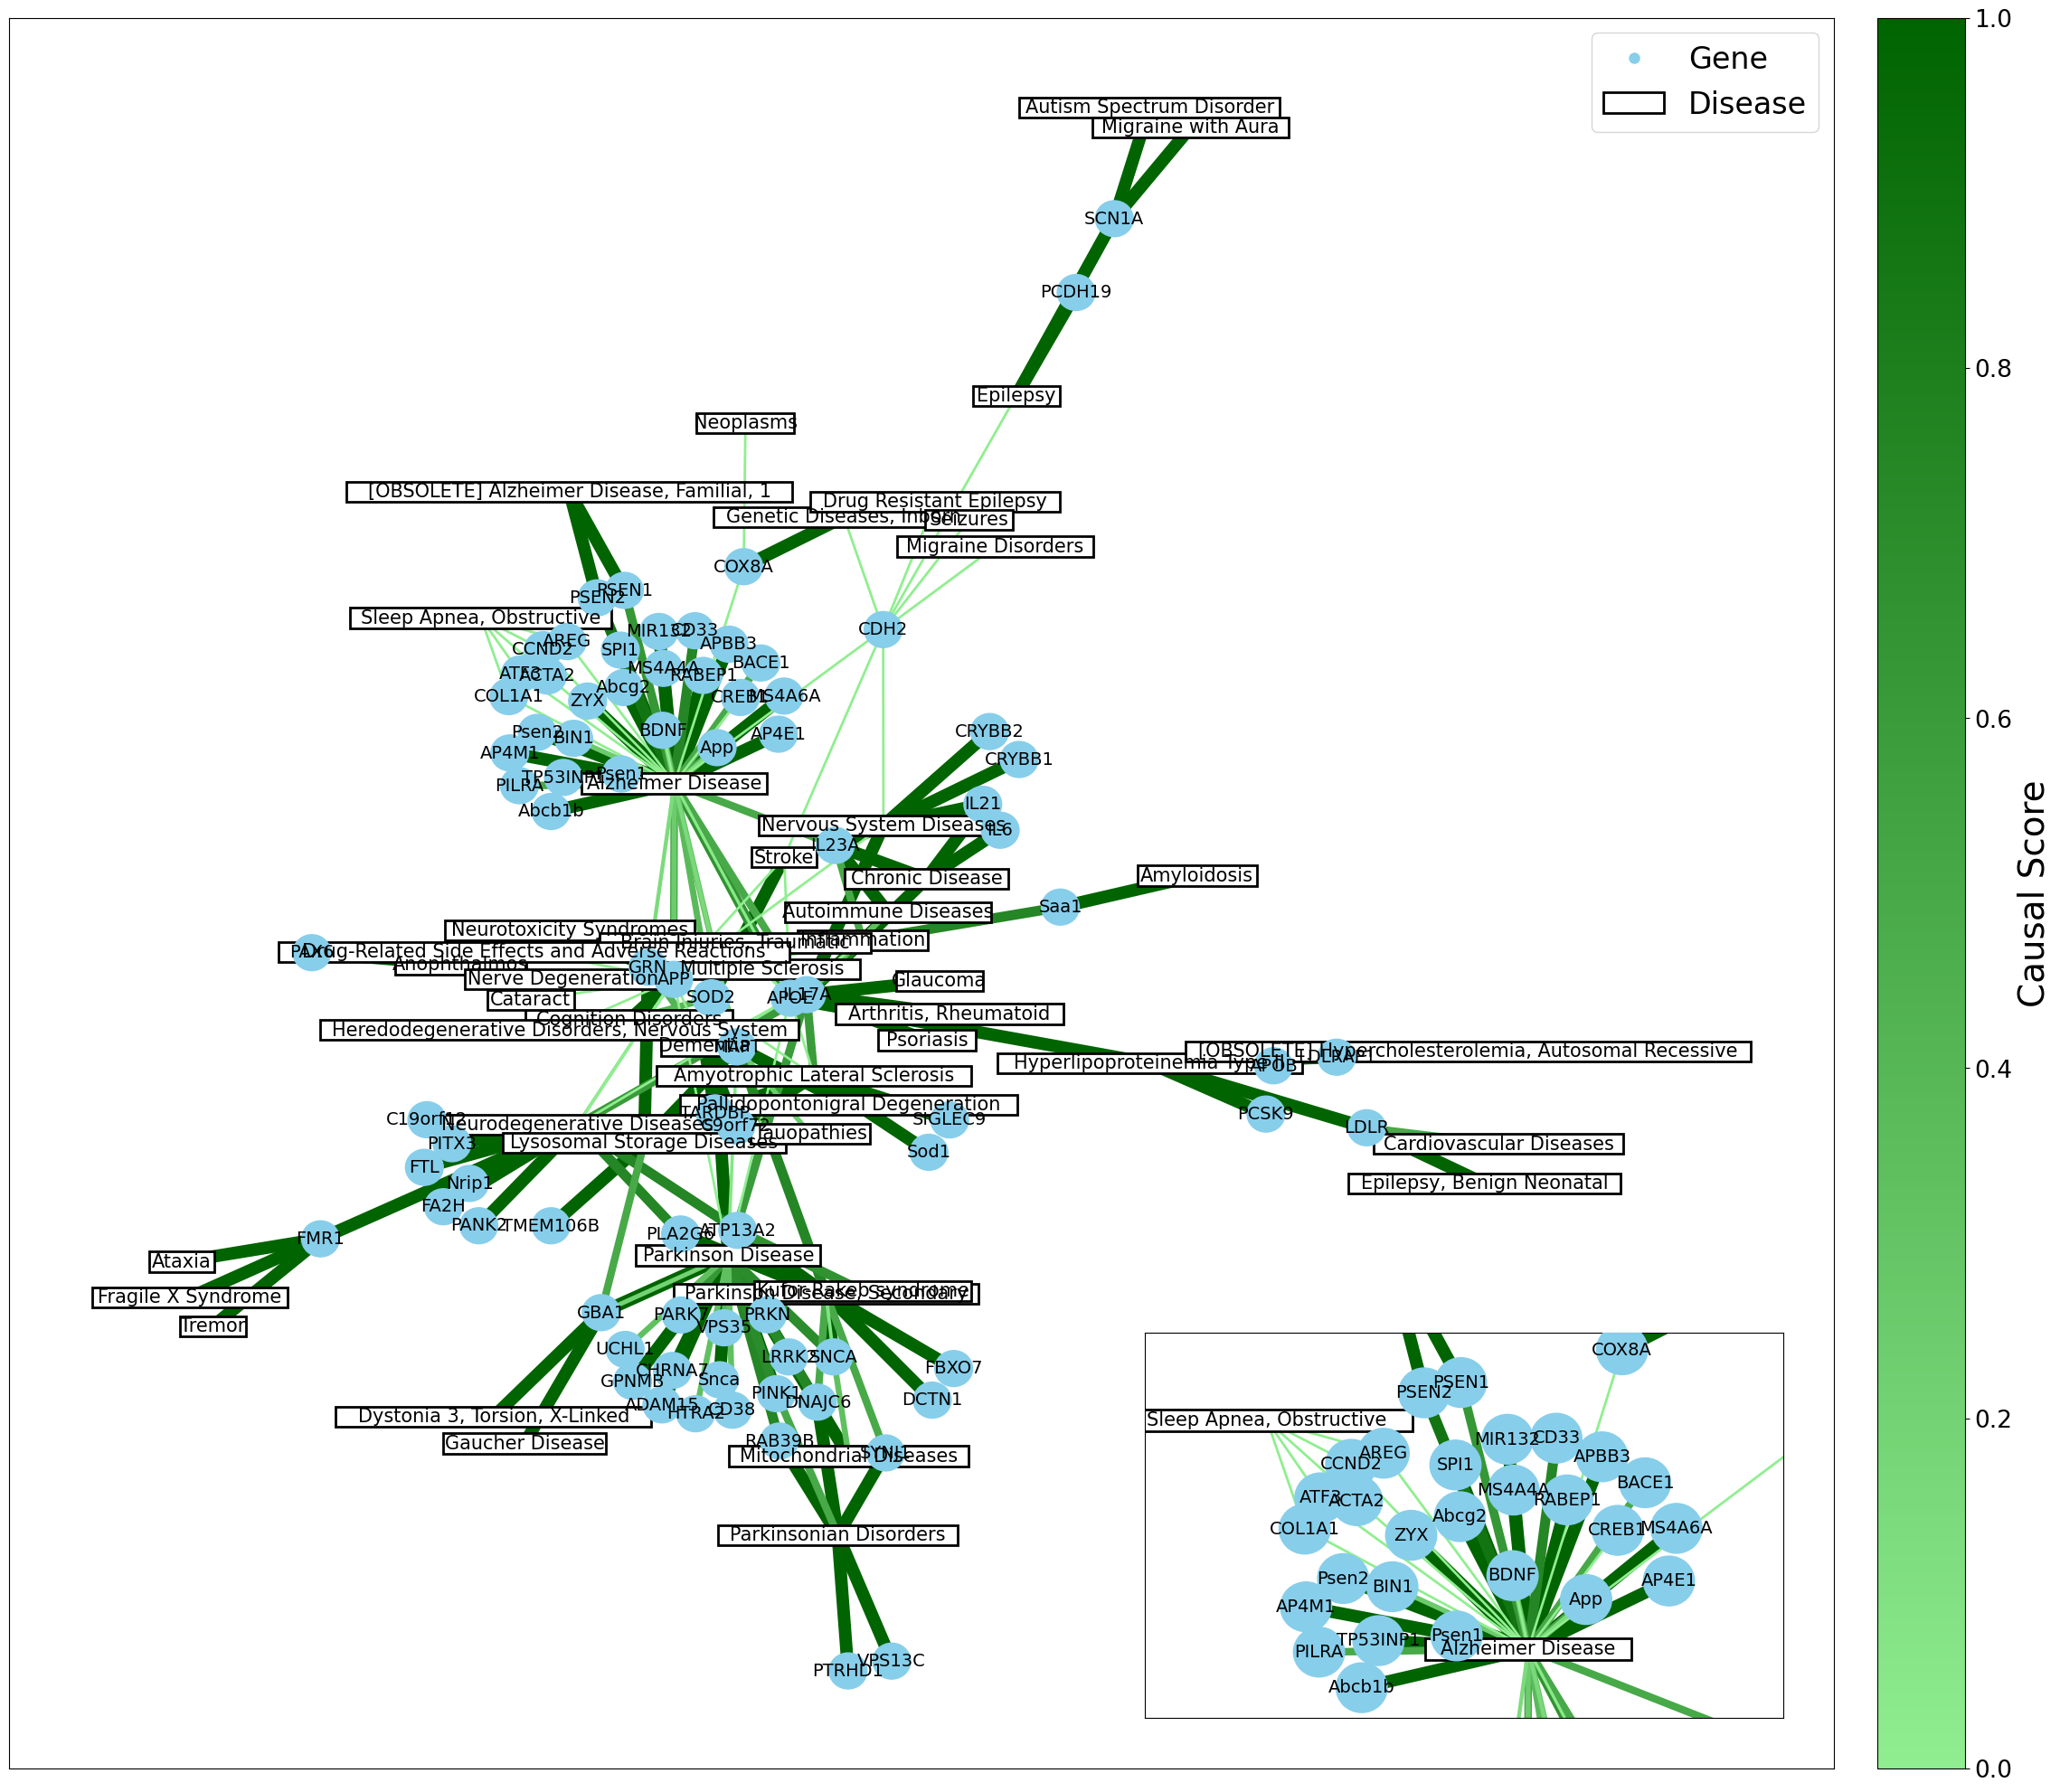

In [15]:
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import random  # Import Python's random module

# Set a random seed for reproducibility
random.seed(60)  # You can choose any number as the seed

# List of genes to remove
genes_to_remove = [
    'TREM2','TYROBP','ATF4','HBB','BRCA2','UBESA','Ubesa','DRD4',
    'LMNA','Lmna','EMD','Emd','FHL1','TMEM43','HEXA','HEXB','NF2',
    'ABCD1','Abcd1','NOTCH2','Galc','SLC40A1','Hamp','HFE','HAMP',
    'TFR2','HJV','GNE','Galc','AR','MSR1','CFTR','HTT','Htt','TCAP',
    'DMD','BRCA1','PQBP1','SHOX','UBE3A','Ube3a'
]

# Sort the DataFrame by 'Causal/Total' and 'Causal_annotations' in descending order and keep the top 250
top_df = df.sort_values(by=['Causal/Total', 'Causal_annotations'], ascending=False).head(250)

# Filter out the genes to remove
top_df_filtered = top_df[~top_df['Gene Symbol'].isin(genes_to_remove)]

# Create a graph
g = ig.Graph()

# Add vertices for Genes (Gene Symbol) and Diseases (Disease Symbol)
genes = top_df_filtered['Gene Symbol'].unique()
diseases = top_df_filtered['Disease Symbol'].unique()
g.add_vertices(list(genes) + list(diseases))

# Add edges with weights (Causal/Total)
for _, row in top_df_filtered.iterrows():
    g.add_edge(row['Gene Symbol'], row['Disease Symbol'], weight=row['Causal/Total'])

# Normalize the edge weights to range from 0 to 1
weights = [e["weight"] for e in g.es]
norm = mcolors.Normalize(vmin=min(weights), vmax=max(weights))

# Create a custom colormap that transitions from light green to dark green
def create_custom_green_cmap(start_color='lightgreen', end_color='darkgreen'):
    colors = [start_color, end_color]
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_green', colors)
    return cmap

green_cmap = create_custom_green_cmap()

# Apply the custom colormap to the normalized weights
edge_colors = [green_cmap(norm(weight)) for weight in weights]

# Plot the graph
fig, ax = plt.subplots(figsize=(25, 20))
layout = g.layout("fr")  # The layout is now reproducible due to the fixed seed

# Plot the main graph
for idx, vertex in enumerate(g.vs["name"]):
    x, y = layout[idx]
    if vertex in genes:
        circle = plt.Circle((x, y), 0.4, color='skyblue', zorder=3)
        ax.add_patch(circle)
        ax.text(x, y, vertex, horizontalalignment='center', verticalalignment='center', color="black", fontsize=14, zorder=4)
    elif vertex in diseases:
        rect_width = max(0.23 * len(vertex), 0.5)  # Adjust width based on text length, with a minimum width
        rect_height = 0.45  # Adjust height based on your layout scale
        rect = mpatches.Rectangle(
            (x - rect_width / 2, y - rect_height / 2), 
            rect_width, 
            rect_height, 
            facecolor="white", edgecolor="black", linewidth=2, zorder=2
        )
        ax.add_patch(rect)
        ax.text(x, y, vertex, horizontalalignment='center', verticalalignment='center', color="black", fontsize=15, zorder=3)

# Plot edges with varying widths and colors
for e in g.es:
    source, target = e.tuple
    x_coords = [layout[source][0], layout[target][0]]
    y_coords = [layout[source][1], layout[target][1]]
    ax.plot(x_coords, y_coords, color=edge_colors[e.index], lw=2 + 8 * norm(e['weight']), zorder=1)

# Add inset axes (zoomed-in region)
inset_ax = inset_axes(ax, width="35%", height="22%", loc="lower right", borderpad=4)

# Define the region to zoom in on (adjust to your needs)
inset_xlim = (-8, 2)  # Adjust to the region you want to zoom in on
inset_ylim = (4, 10.2)  # Adjust to the region you want to zoom in on

inset_ax.set_xlim(inset_xlim)
inset_ax.set_ylim(inset_ylim)

# Replot the same graph inside the inset
for idx, vertex in enumerate(g.vs["name"]):
    x, y = layout[idx]
    if inset_xlim[0] <= x <= inset_xlim[1] and inset_ylim[0] <= y <= inset_ylim[1]:
        if vertex in genes:
            circle = plt.Circle((x, y), 0.4, color='skyblue', zorder=3)
            inset_ax.add_patch(circle)
            inset_ax.text(x, y, vertex, horizontalalignment='center', verticalalignment='center', color="black", fontsize=14, zorder=4)
        elif vertex in diseases:
            rect_width = max(0.19 * len(vertex), 0.5)  # Adjust width based on text length, with a minimum width
            rect_height = 0.35  # Adjust height based on your layout scale
            rect = mpatches.Rectangle(
                (x - rect_width / 2, y - rect_height / 2), 
                rect_width, 
                rect_height, 
                facecolor="white", edgecolor="black", linewidth=2, zorder=2
            )
            inset_ax.add_patch(rect)
            inset_ax.text(x, y, vertex, horizontalalignment='center', verticalalignment='center', color="black", fontsize=15, zorder=3)

# Plot edges inside the inset
for e in g.es:
    source, target = e.tuple
    x_coords = [layout[source][0], layout[target][0]]
    y_coords = [layout[source][1], layout[target][1]]
    if (inset_xlim[0] <= x_coords[0] <= inset_xlim[1] and inset_ylim[0] <= y_coords[0] <= inset_ylim[1]) or \
       (inset_xlim[0] <= x_coords[1] <= inset_xlim[1] and inset_ylim[0] <= y_coords[1] <= inset_ylim[1]):
        inset_ax.plot(x_coords, y_coords, color=edge_colors[e.index], lw=2 + 8 * norm(e['weight']), zorder=1)

# Adjust color bar placement with padding
sm = plt.cm.ScalarMappable(cmap=green_cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, pad=0.02)  # Adjust the padding to make sure it fits well
cbar.set_label('Causal Score', fontsize=28)
cbar.ax.tick_params(labelsize=19)

# Adjust layout to make sure everything fits in the figure
plt.tight_layout()

# Add legend to the main plot with increased fontsize
ax.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Gene', markerfacecolor='skyblue', markersize=10),
    mpatches.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', linewidth=2, label='Disease')
], loc='upper right', fontsize=24)  # Increase fontsize to 14

ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([])  # Remove y-axis ticks

inset_ax.set_xticks([])  # Remove x-axis ticks
inset_ax.set_yticks([])  # Remove y-axis ticks


plt.show()

# Save the graph as an image file
fig.savefig('cred_causal_ratio_with_inset.pdf')
fig.savefig('cred_causal_ratio_with_inset.png', bbox_inches='tight')

